In [475]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, fbeta_score, precision_recall_curve,f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

In [476]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [477]:
from xgboost import XGBClassifier, plot_importance

In [478]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql

In [479]:
from sklearn import linear_model, naive_bayes, svm, neural_network
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

In [480]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from xgboost import XGBClassifier, plot_importance

In [481]:
df = pd.read_csv('bank-additional-full.csv', sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [482]:
#convert y to 1 and 0
def convert_y(name):
    if name == 'yes':
        return 1
    elif name == 'no':
        return 0

In [483]:
#combine education categories
def education(name):
    if name == 'basic.9y' or name == 'basic.4y' or name == 'basic.6y' or name == 'illiterate':
        return 'basic'
    else:
        return name

In [484]:
#replace month string with numbers
df.month.replace(('jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'),(1,2,3,4,5,6,7,8,9,10,11,12), inplace = True)

In [485]:
#replace week string with numbers
df.day_of_week.replace(('mon', 'tue', 'wed','thu','fri'), (1,2,3,4,5), inplace = True)

In [486]:
#duration is the information I shouln't have excess to,  which happens after the phone call. So drop this one for prediction
df['y'] = df['y'].apply(convert_y)
df['education'] = df['education'].apply(education)
df = df.drop(['duration'], axis = 1)#drop duration

In [487]:
#get dummy variables
df = pd.get_dummies(df, drop_first=True)

In [517]:
y_value = df.y.value_counts()

In [521]:
sign_up_percentage = y_value[1]/(y_value[0] + y_value[1])
sign_up_percentage

0.11265417111780131

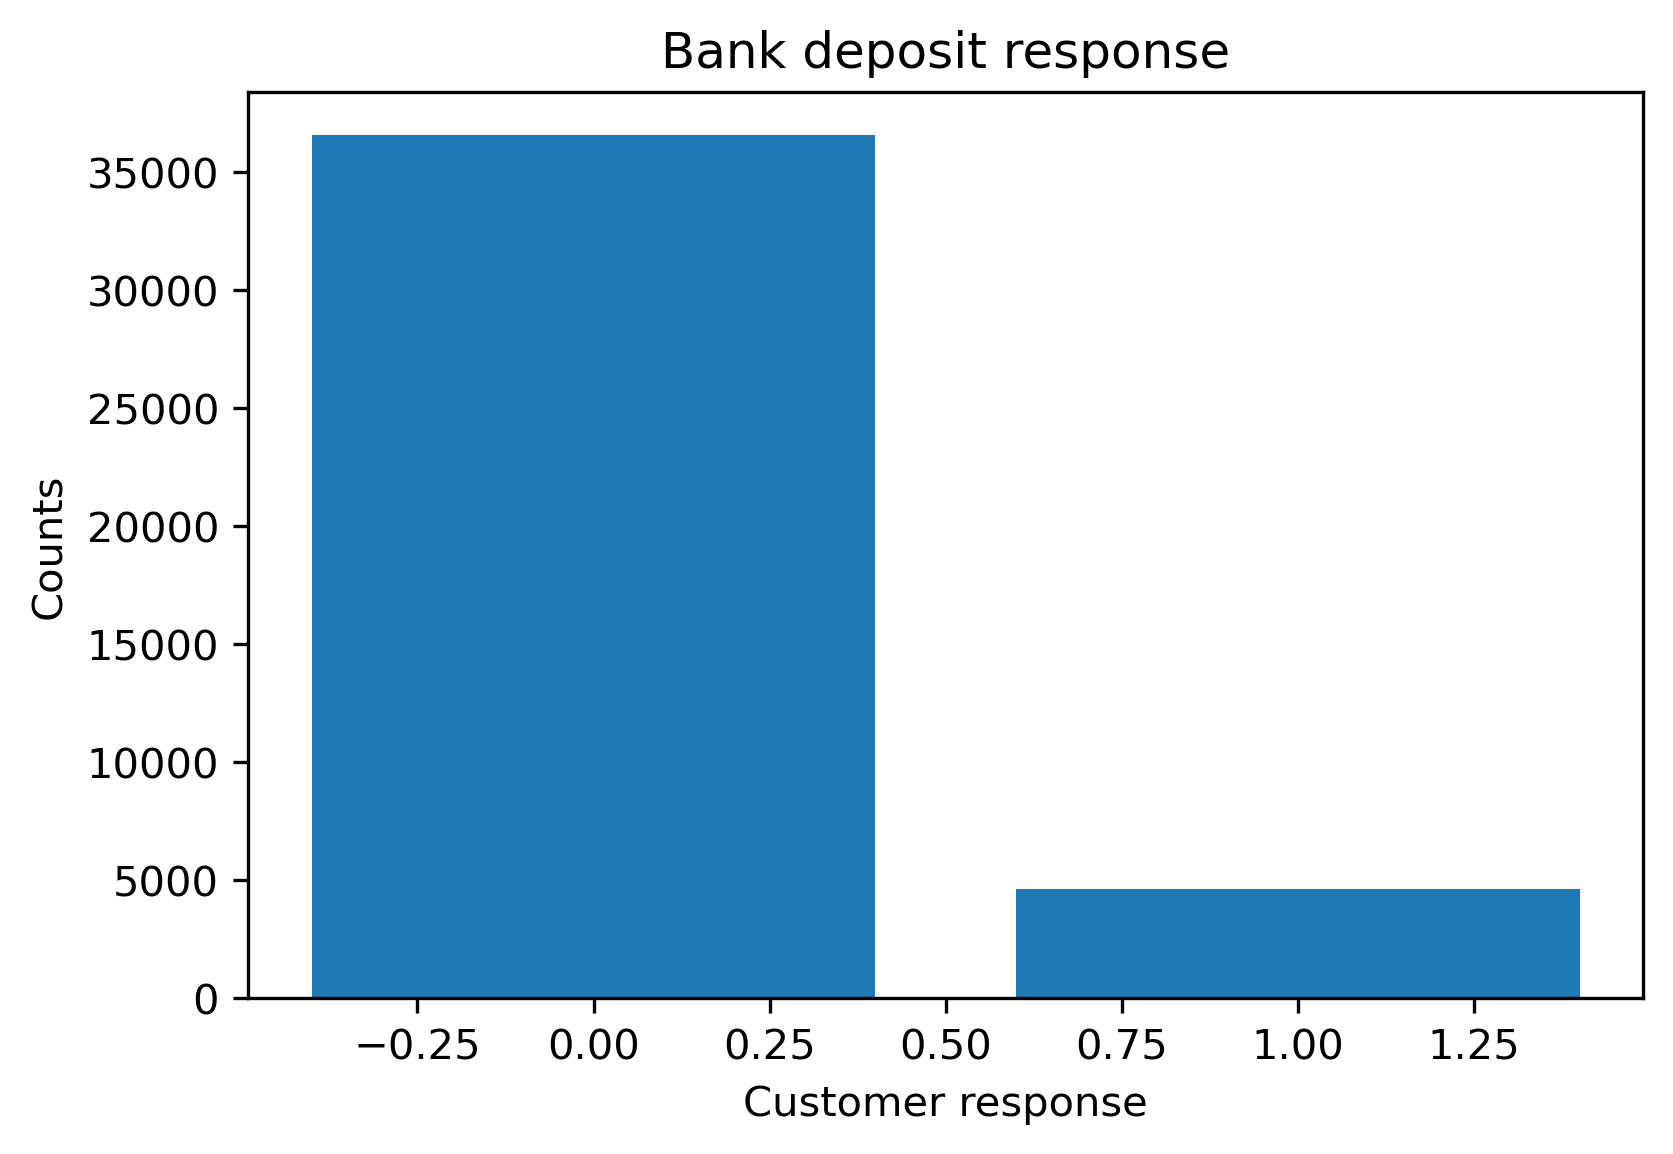

In [524]:
#plot response barchart
plt.bar(df.y.value_counts().index,df.y.value_counts() )
plt.title('Bank deposit response')
plt.xlabel('Customer response')
plt.ylabel('Counts')
plt.savefig('imbalanced_data.png')

In [490]:
df_all_feature = df.copy()

#### Feature importance from random forest

In [491]:
rf = RandomForestClassifier(max_depth=4, n_estimators= 500, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [156]:
importances = rf.feature_importances_

In [190]:
features = df_all_feature.drop('y',axis = 1).columns
importances = rf.feature_importances_
feat_import = pd.DataFrame({'features': features, 'importances':importances})
feat_import.sort_values(by = 'importances', ascending = True, inplace = True)

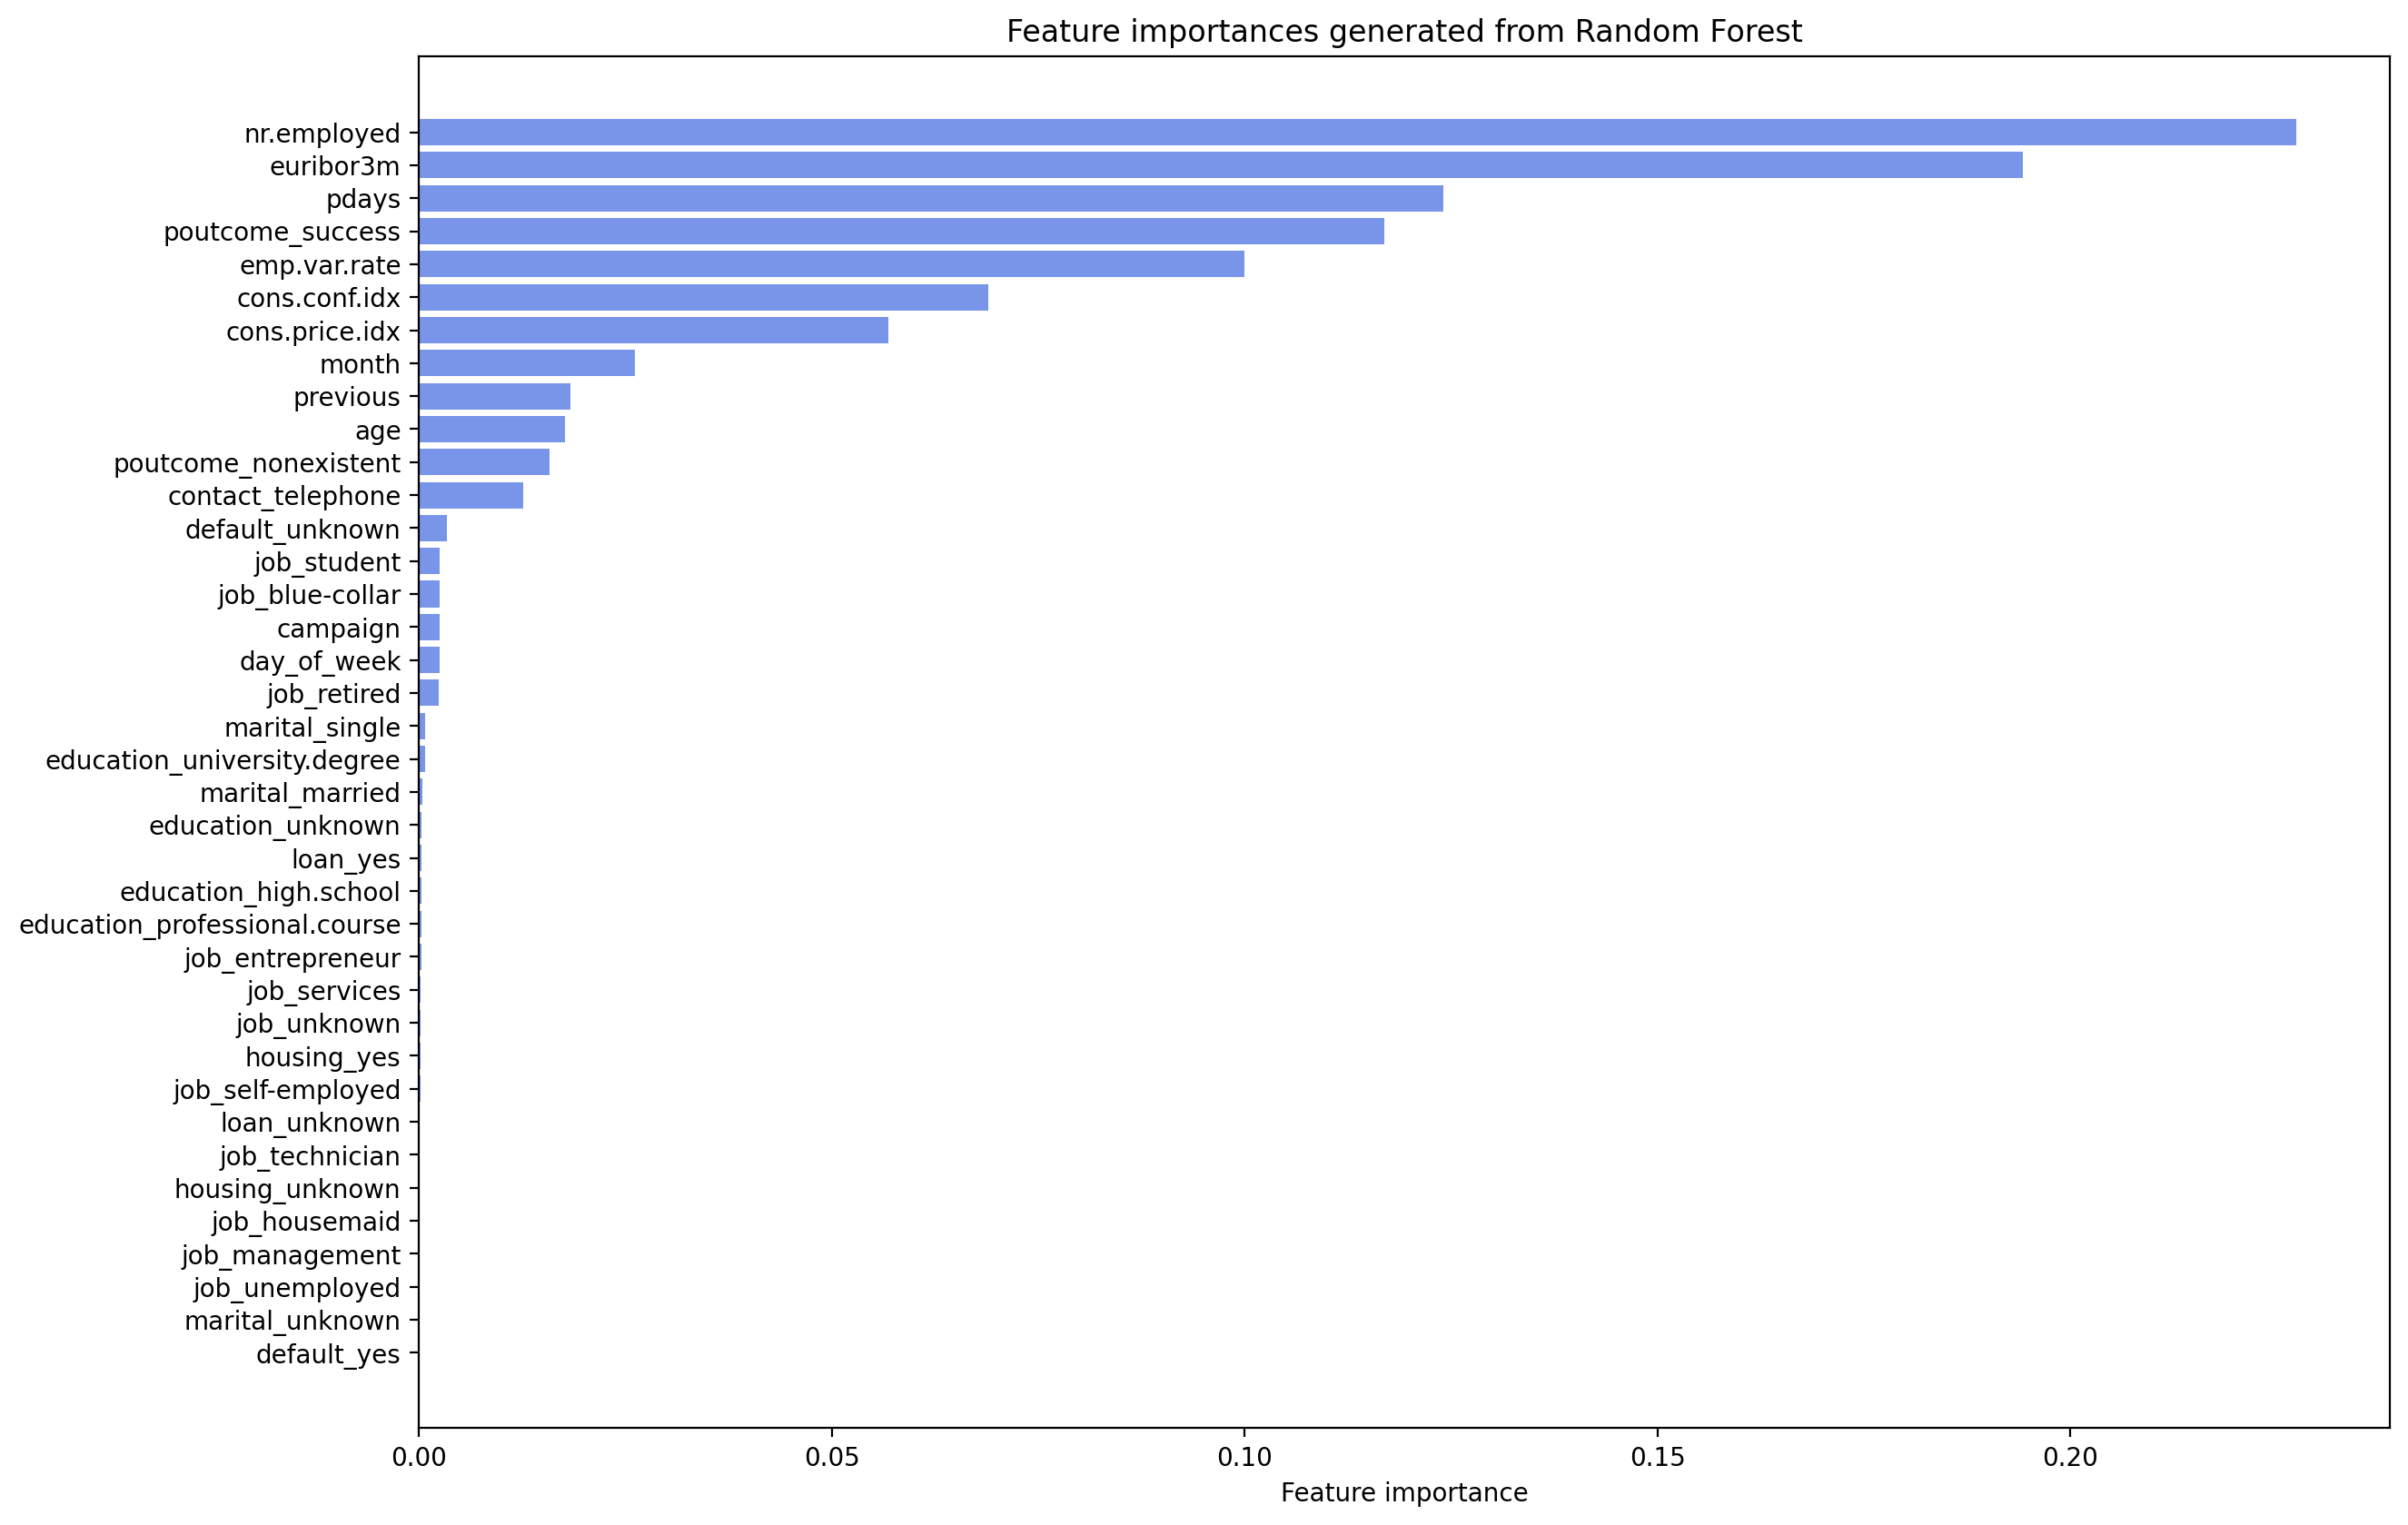

In [191]:

plt.figure(figsize=(14,10), dpi= 200);
plt.barh(feat_import.features, feat_import.importances,  color = 'royalblue', alpha = 0.7);
plt.title("Feature importances generated from Random Forest");
plt.xlabel('Feature importance')
plt.yticks(fontsize = 10);
plt.savefig('feature importance.png', dpi = 200)

In [254]:
#choose top 12 features for further analysis
chosen_features = feat_import.features[-12:-1]
df_chosen = df_all_feature[chosen_features.sort_index()]

In [285]:
df_chosen = pd.concat([df_chosen,df_all_feature.y], axis = 1)

#### Grid search for parameters

In [370]:
#split hold out set
X_train,X_holdout, y_train, y_holdout = train_test_split(df_chosen.drop('y', axis = 1), df_chosen.y, test_size = 0.2, random_state = 28, stratify = df_chosen.y)

In [371]:
kf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 28)

In [372]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
# X_scaled = processing.scale(X_train)
X_holdout_scaled = scaler.transform(X_holdout)

In [373]:
adasyn = ADASYN(random_state=28)
X_resampled, y_resampled = adasyn.fit_sample(X_scaled, y_train)

Grid search for best parameters, code from kevin chiv's repo with modifications
https://github.com/kevinchiv/Predicting-Kickstarter-Success/blob/master/02%20-%20Classification%20Modeling.ipynb

In [374]:
classifiers = {'KNN': KNeighborsClassifier(), 
               'LR': LogisticRegression(max_iter = 10000, solver ='saga'), 
               'RF': RandomForestClassifier(), 
               'XGB': XGBClassifier()
              }

In [375]:
param_dict = {'KNN': {'n_neighbors': [3, 5, 7, 9]}, 
              'LR': {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, 
              'RF': {'n_estimators': [100, 250, 500, 1000], 
                     'max_depth': [3, 4, 5]},
              'XGB': {'n_estimators': [100, 250, 500, 1000], 
                      'max_depth': [3, 4, 5], 
                      'learning_rate': [0.001, 0.01, 0.1]}
             }

In [376]:
results_dict = {}
for classifier_name, classifier in classifiers.items():
    params = param_dict[classifier_name]
    grid = GridSearchCV(classifier, params, cv = kf, return_train_score = True,
                        n_jobs = -1, scoring = 'f1', verbose = True)

    grid.fit(X_resampled, y_resampled)

    results = grid.cv_results_
    scores = list(zip(results['params'], results['mean_train_score'], results['mean_test_score']))
    results_dict[classifier_name] = scores

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   43.0s finished


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  2.6min finished


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 10.9min finished


In [334]:
results_dict

{'KNN': [({'n_neighbors': 3}, 0.8632254172503059, 0.8105746035216171),
  ({'n_neighbors': 5}, 0.8312478098045114, 0.7897757173954613),
  ({'n_neighbors': 7}, 0.8088929322322388, 0.7740290522158896),
  ({'n_neighbors': 9}, 0.7909103307697701, 0.7604690717902445)],
 'LR': [({'C': 0.001}, 0.6471266900030025, 0.6470397150187379),
  ({'C': 0.01}, 0.64334249548353, 0.6430808655867266),
  ({'C': 0.1}, 0.6415190184985918, 0.6415082175630401),
  ({'C': 1}, 0.6413192464803165, 0.6413280493715068),
  ({'C': 10}, 0.6412938720524874, 0.6413139959232952),
  ({'C': 100}, 0.6412938720524874, 0.6413139959232952),
  ({'C': 1000}, 0.6412938720524874, 0.6413139959232952)],
 'RF': [({'max_depth': 3, 'n_estimators': 100},
   0.6504359276884781,
   0.6502780241321119),
  ({'max_depth': 3, 'n_estimators': 250},
   0.6503684066332167,
   0.6502659349819133),
  ({'max_depth': 3, 'n_estimators': 500},
   0.6503086305944419,
   0.6503394957236613),
  ({'max_depth': 3, 'n_estimators': 1000},
   0.6504425828777899,

Optimized for recall score:
Conclusion:
Knn choose n_neighbors = 3, LR choose  C = 0.01, RF choose max_depth = 4, n_estimators = 500,
XGB choose learning rate = 0.1, max_depth = 5, n_estimator = 1000

Optimized for f1 score:
Conclusion:
Knn choose n_neighbors = 3, LR choose  C = 0.01, RF choose max_depth = 4, n_estimators = 250,
XGB choose learning rate = 0.1, max_depth = 5, n_estimator = 1000

In [398]:
knn = KNeighborsClassifier(n_neighbors=3)
rf = RandomForestClassifier(max_depth=4, n_estimators= 500, random_state=0)
logit = LogisticRegression(C = 0.01, max_iter = 10000, solver ='saga')
XGB = XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 1000)

XGB is the best performing model

In [293]:
for i, (train, test) in enumerate(kf.split(X_resampled, y_resampled)):
    rf.fit(X_resampled[train], y_resampled[train])
    print(confusion_matrix(y_resampled[test], rf.predict(X_resampled[test])))
    print('recall score:', recall_score(y_resampled[test], rf.predict(X_resampled[test])),
          'F_beta score', fbeta_score(y_resampled[test], rf.predict(X_resampled[test]), beta = 1))

[[4269 1579]
 [2249 3639]]
recall score: 0.6180366847826086 F_beta score 0.6553214478660184
[[4308 1540]
 [2228 3660]]
recall score: 0.6216032608695652 F_beta score 0.6601731601731602
[[4292 1556]
 [2167 3721]]
recall score: 0.6319633152173914 F_beta score 0.6665472458575907
[[4272 1575]
 [2252 3636]]
recall score: 0.6175271739130435 F_beta score 0.6551941616361835
[[4329 1518]
 [2222 3665]]
recall score: 0.6225581790385596 F_beta score 0.6621499548328816


In [379]:
for i, (train, test) in enumerate(kf.split(X_resampled, y_resampled)):
    XGB.fit(X_resampled[train], y_resampled[train])
    print(confusion_matrix(y_resampled[test], XGB.predict(X_resampled[test])))
    print('recall score:', recall_score(y_resampled[test], XGB.predict(X_resampled[test])),
          'F_beta score', fbeta_score(y_resampled[test], XGB.predict(X_resampled[test]), beta = 1))

[[5469  379]
 [ 951 4903]]
recall score: 0.8375469764263751 F_beta score 0.8805675287356323
[[5465  383]
 [ 916 4937]]
recall score: 0.8434990603109517 F_beta score 0.8837375816700975
[[5483  365]
 [ 923 4930]]
recall score: 0.8423030924312318 F_beta score 0.8844635809113743
[[5446  401]
 [ 900 4953]]
recall score: 0.8462327011788826 F_beta score 0.8839118408137772
[[5437  410]
 [ 896 4957]]
recall score: 0.8469161113958654 F_beta score 0.8836007130124778


Predicting the hold out set

In [399]:
classifiers_opti = {'KNN': KNeighborsClassifier(n_neighbors=5), 
                    'RF': RandomForestClassifier(max_depth=4, n_estimators= 500, random_state=0),
                    'LR': LogisticRegression(C= 0.01, max_iter = 10000, solver ='saga'), 
                    'XGB': XGBClassifier(learning_rate = 0.1, max_depth = 5, n_estimators = 1000)
              }

In [492]:
knn.fit(X_resampled, y_resampled)
rf.fit(X_resampled, y_resampled)
logit.fit(X_resampled, y_resampled)
xgb.fit(X_resampled, y_resampled)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [401]:
print('knn confusion matrix:','\n',confusion_matrix(y_holdout, knn.predict(X_holdout_scaled)))
print('knn recall score:', recall_score(y_holdout, knn.predict(X_holdout_scaled)))
print('knn f1 score:',f1_score(y_holdout, knn.predict(X_holdout_scaled)))

print('rf confusion matrix:','\n',confusion_matrix(y_holdout, rf.predict(X_holdout_scaled)))
print('rf recall score:', recall_score(y_holdout, rf.predict(X_holdout_scaled)))
print('rf f1 score:',f1_score(y_holdout, rf.predict(X_holdout_scaled)))

print('logistic confusion matrix:','\n',confusion_matrix(y_holdout, logit.predict(X_holdout_scaled)))
print('logistic recall score:', recall_score(y_holdout, logit.predict(X_holdout_scaled)))
print('logistic f1 score:',f1_score(y_holdout, logit.predict(X_holdout_scaled)))

print('XGB confusion matrix:','\n',confusion_matrix(y_holdout, xgb.predict(X_holdout_scaled)))
print('XGB recall score:', recall_score(y_holdout, xgb.predict(X_holdout_scaled)))
print('XGB f1 score:',f1_score(y_holdout, xgb.predict(X_holdout_scaled)))


knn confusion matrix: 
 [[6723  587]
 [ 513  415]]
knn recall score: 0.44719827586206895
knn f1 score: 0.4300518134715026
rf confusion matrix: 
 [[5306 2004]
 [ 271  657]]
rf recall score: 0.7079741379310345
rf f1 score: 0.36611869601560326
logistic confusion matrix: 
 [[5696 1614]
 [ 306  622]]
logistic recall score: 0.6702586206896551
logistic f1 score: 0.393173198482933
XGB confusion matrix: 
 [[6804  506]
 [ 503  425]]
XGB recall score: 0.4579741379310345
XGB f1 score: 0.457235072619688


In [523]:
precision_score(y_holdout, xgb.predict(X_holdout_scaled))

0.4564983888292159

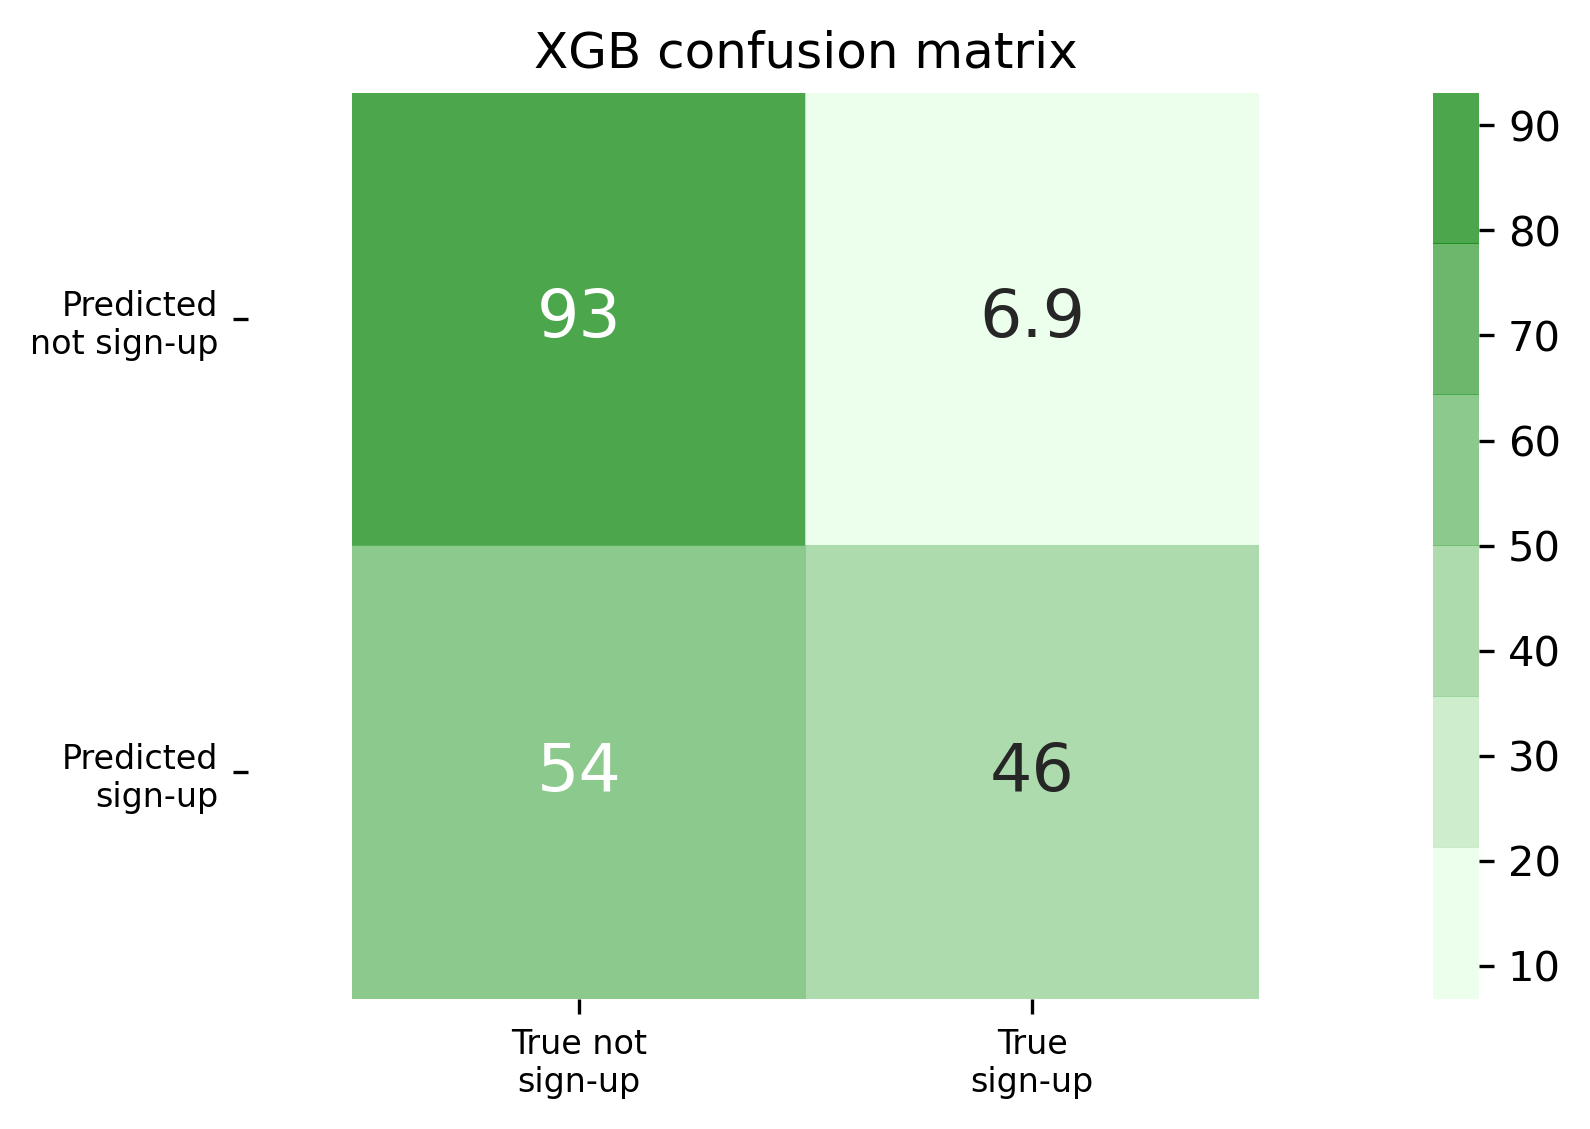

In [516]:
#Plot the selected model confusion matrix
cm = confusion_matrix(y_holdout, xgb.predict(X_holdout_scaled))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
percentage = lambda x: round(x*100, ndigits=1)
df_cm = pd.DataFrame(cm, index = ['Predicted\nnot sign-up', 'Predicted\nsign-up'], 
                         columns = ['True not\nsign-up', 'True\nsign-up'])
cm_plot = sns.heatmap(df_cm.apply(percentage), annot=True, annot_kws={"size": 16}, 
                      cmap=sns.light_palette("green"), alpha = 0.7)

plt.title('XGB confusion matrix')
plt.axis('equal');
plt.yticks(rotation = 0, fontsize = 8);
plt.xticks(fontsize = 8);
plt.savefig('XGB confusion matrix.png')

In [402]:
recall_scores = [recall_score(y_holdout, knn.predict(X_holdout_scaled)),recall_score(y_holdout, rf.predict(X_holdout_scaled)),recall_score(y_holdout, logit.predict(X_holdout_scaled)),recall_score(y_holdout, xgb.predict(X_holdout_scaled))]

In [403]:
f1_scores = [f1_score(y_holdout, knn.predict(X_holdout_scaled)),f1_score(y_holdout, rf.predict(X_holdout_scaled)),f1_score(y_holdout, logit.predict(X_holdout_scaled)),f1_score(y_holdout, xgb.predict(X_holdout_scaled)) ]

In [406]:
df_score = pd.DataFrame({'Classifier':['KNN', 'Logistic', 'Random Forest', 'XGB'], 'recall score': recall_scores, 'f1 scores':f1_scores})

In [407]:
df_score

,Classifier,recall score,f1 scores
0,KNN,0.447198,0.430052
1,Logistic,0.707974,0.366119
2,Random Forest,0.670259,0.393173
3,XGB,0.457974,0.457235


Models were optimized for recall score

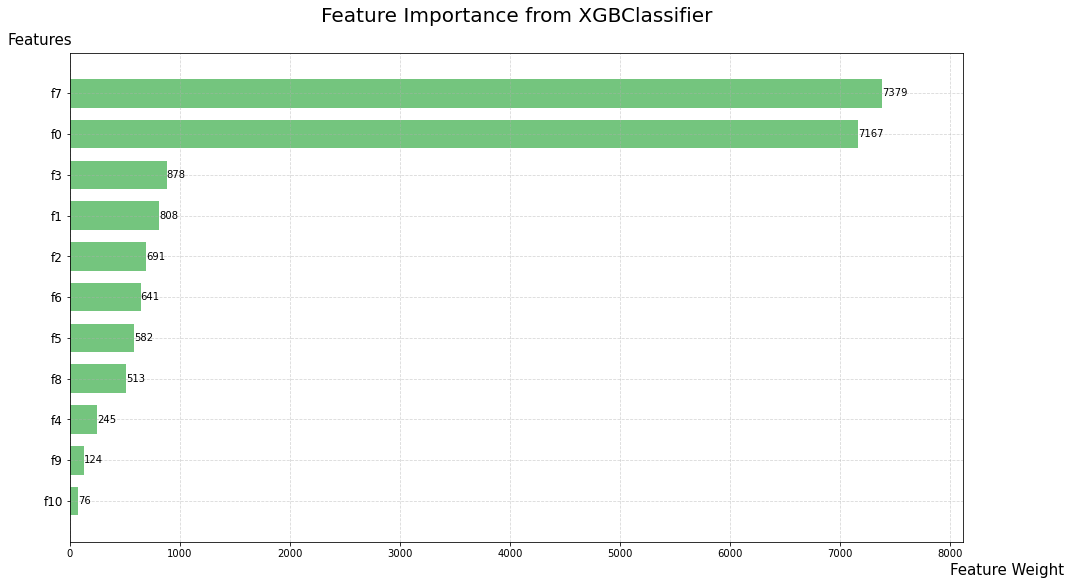

In [272]:
#plot feature importance with XGB
fig, ax = plt.subplots(figsize=(16,9));
plot_importance(XGB, height = 0.7, ax = ax, importance_type = 'weight', 
                color = sns.xkcd_rgb["medium green"], alpha = 0.7);

plt.xlabel(xlabel = 'Feature Weight', size = 15, x = 1.05);
plt.ylabel(ylabel = 'Features', size = 15, rotation = 0, y = 1.01);
plt.title('Feature Importance from XGBClassifier', fontsize=20, y = 1.05);
plt.yticks(fontsize=12);
plt.grid(linestyle='--', alpha=0.5)

#### Plot ROC curve for all four models

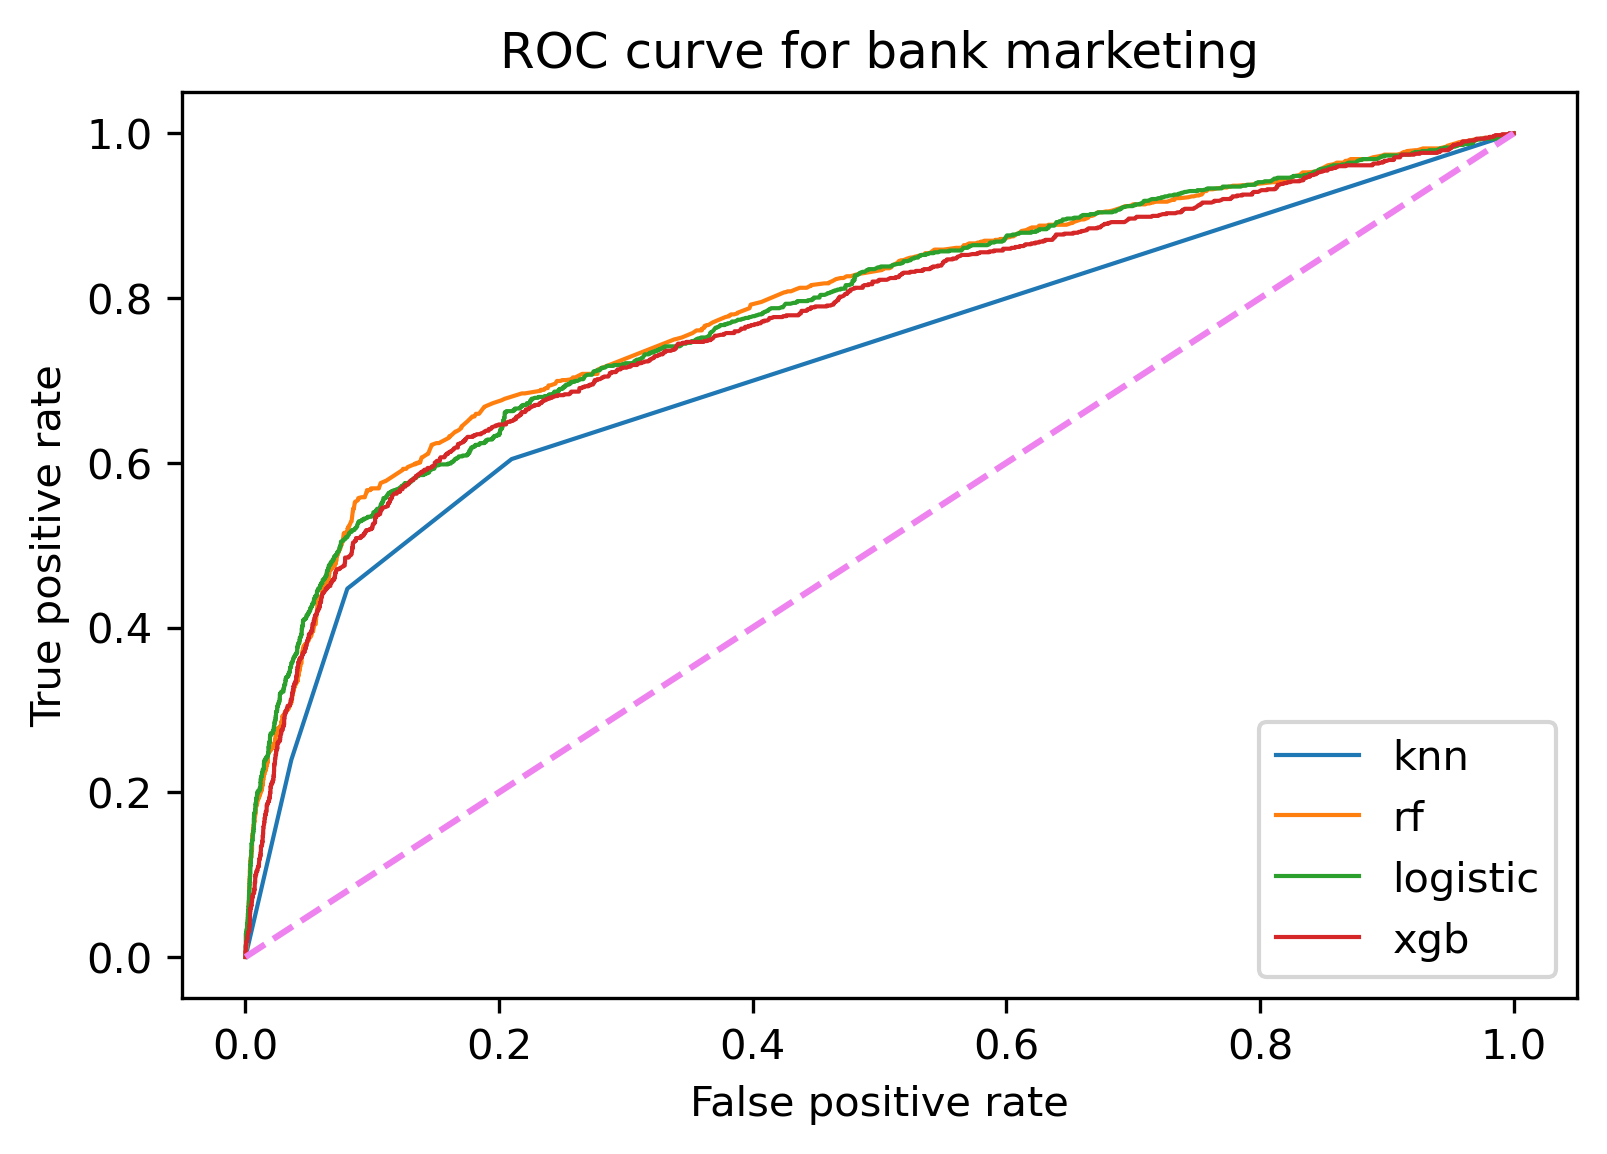

In [397]:
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_holdout, knn.predict_proba(X_holdout_scaled)[:,1])
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_holdout, rf.predict_proba(X_holdout_scaled)[:,1])
fpr_logit, tpr_logit, thresholds_logit = roc_curve(y_holdout, logit.predict_proba(X_holdout_scaled)[:,1])
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_holdout, xgb.predict_proba(X_holdout_scaled)[:,1])

plt.plot(fpr_knn, tpr_knn,lw=1)
plt.plot(fpr_rf, tpr_rf,lw=1)
plt.plot(fpr_logit, tpr_logit,lw=1)
plt.plot(fpr_xgb, tpr_xgb,lw=1)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.legend(['knn','rf', 'logistic', 'xgb'], loc = 'lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for bank marketing');
# print("Roc_auc score = ", roc_auc_score(y_holdout, xgb.predict_proba(X_holdout_scaled)[:,1]))
plt.savefig('ROC curve for bank marketing.png')